In [1]:
import tensorflow as tf
from tensorflow import keras, nn
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 16]

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the sample data from integers to floating-point numbers:

In [2]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

for X, y in zip(x_test, y_test):
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: (28, 28)
Shape of y: () uint8


In [3]:
classes = list(map(str,range(10)))

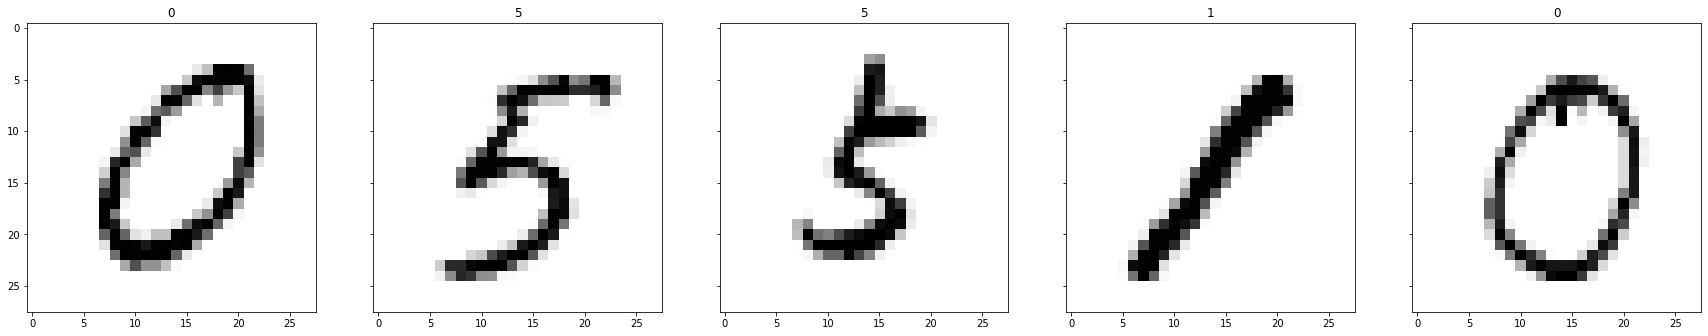

In [4]:
fig, axs = plt.subplots(1, 5, sharey=True)
for i, idx in enumerate(np.random.choice(np.arange(len(x_train)), 5, replace=False)):
    axs[i].imshow(x_train[idx], cmap="Greys")
    axs[i].set_title(classes[y_train[idx]])

## Build a machine learning model

Build a `keras.Sequential` model by stacking layers.

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if len(tf.config.list_physical_devices("GPU")) else "cpu"
print(f"Using {device} device")

model = keras.models.Sequential([
    layers.Conv2D(3, 3, 1, input_shape=(28, 28, 1), activation="relu"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10)
])

model.summary()

Using cuda device
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 3)         30        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 3)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 507)               0         
                                                                 
 dense (Dense)               (None, 512)               260096    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 265,256
Trainable params: 265,256
Non-trainable params: 0
________________________________

Define a loss function for training using `losses.SparseCategoricalCrossentropy`, which takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [6]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=.1)

Before we start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) to the optimizer we created, set the `loss` to the `loss_fn` function we defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [7]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate 

Use the `Model.fit` method to adjust our model parameters and minimize the loss: 

In [8]:
model.fit(x_train, y_train, epochs=2, batch_size=64)

Epoch 1/2
938/938 [==============================] - 27s 15ms/step - loss: 0.2240 - accuracy: 0.9352
Epoch 2/2
938/938 [==============================] - 15s 16ms/step - loss: 0.0816 - accuracy: 0.9750


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [9]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 2s - loss: 0.0716 - accuracy: 0.9757 - 2s/epoch - 7ms/step


[0.07161889970302582, 0.9757000207901001]

In [10]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

# Saving Models

In [11]:
probability_model.save("model.h5")

# Loading Models

In [12]:
model = keras.models.load_model("model.h5")
model.compile()

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                265256    
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 265,256
Trainable params: 265,256
Non-trainable params: 0
_________________________________________________________________


We can now make predictions with this model.

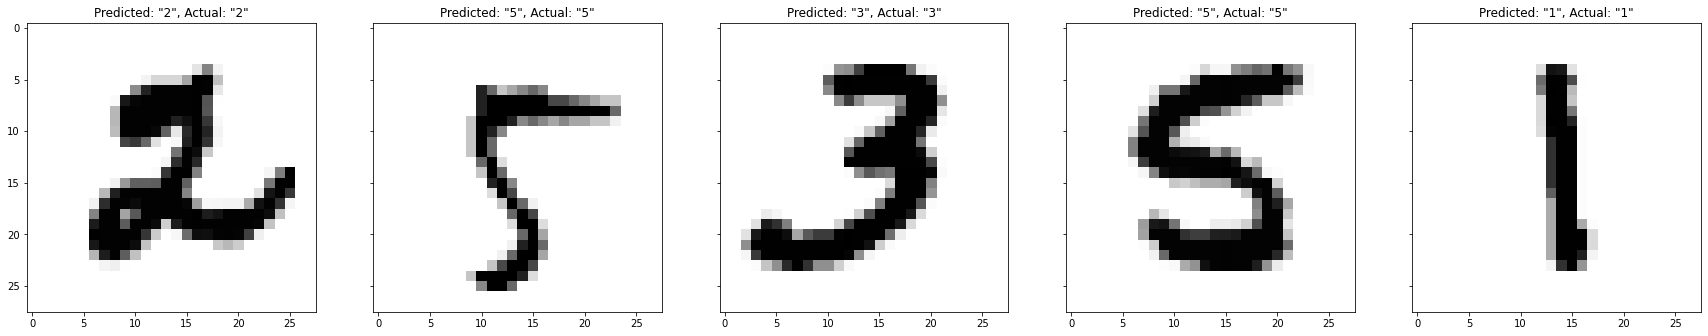

In [14]:
fig, axs = plt.subplots(1, 5, sharey=True)
for i, idx in enumerate(np.random.choice(np.arange(len(x_test)), 5, replace=False)):
    x, y = x_test[idx], y_test[idx]
    axs[i].imshow(x, cmap="Greys")
    pred = model(tf.expand_dims(x, 0))
    predicted, actual = classes[tf.argmax(pred,1)[0]], classes[y]
    axs[i].set_title(f'Predicted: "{predicted}", Actual: "{actual}"')